In [62]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import xgboost as xgb
import math
from sklearn.model_selection import train_test_split
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline


In [264]:
df_train = pd.read_csv("../data/train.csv", parse_dates=['timestamp'])
df_test = pd.read_csv("../data/test.csv", parse_dates=['timestamp'])
df_macro = pd.read_csv("../data/macro.csv", parse_dates=['timestamp'])

# df_train.head()
print(df_train.shape)
print(df_test.shape)
print(df_macro.shape)

(30471, 292)
(7662, 291)
(2484, 100)


In [263]:
df_train['year_month'] = (df_train.timestamp.dt.month + df_train.timestamp.dt.year * 100)
grouped_df = df_train.groupby('year_month')['price_doc'].aggregate(np.mean).reset_index()
grouped_df.columns = ['year_month','price_doc_mean']
grouped_df2 = df_train.groupby('year_month')['price_doc'].aggregate(np.std).reset_index()
grouped_df2.columns = ['year_month','price_doc_std']
grouped_df_train = grouped_df.merge(grouped_df2,on='year_month')
print(df_train['year_month'].min(),df_train['year_month'].max())

(201108, 201506)


In [245]:
df_train = df_train.merge(grouped_df_train, on='year_month')
df_train['price_doc_zScore'] = (df_train['price_doc'] - df_train['price_doc_mean'])/df_train['price_doc_std']

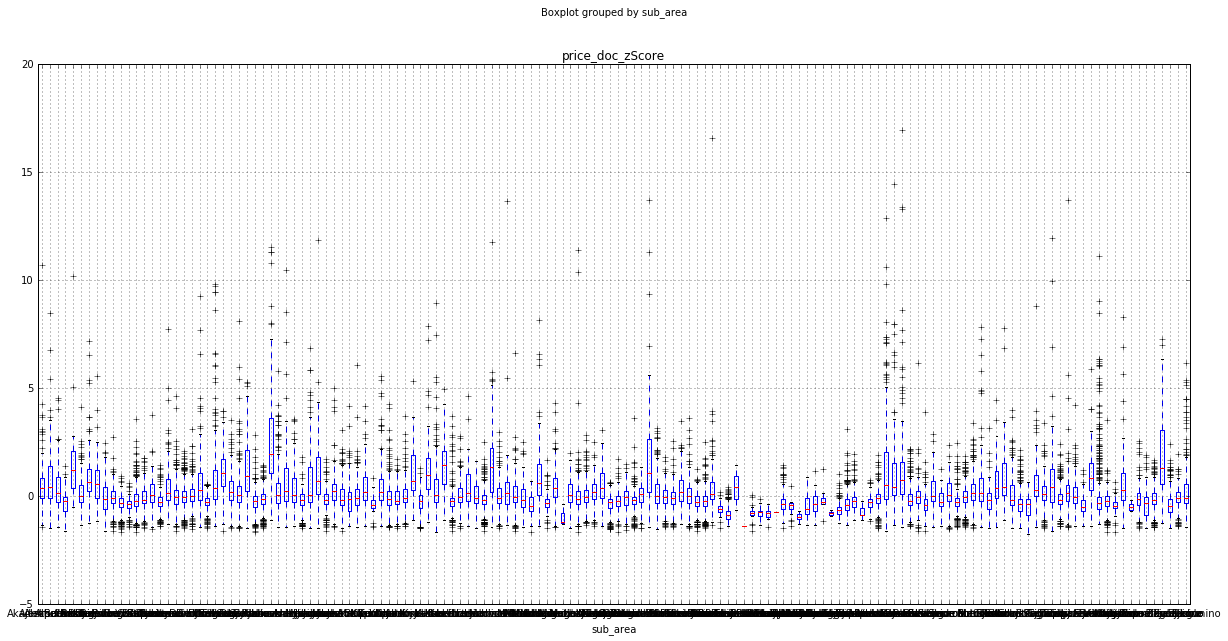

In [246]:
df_train.boxplot('price_doc_zScore','sub_area',figsize=(20,10))

In [247]:
grouped_df = df_train.groupby('sub_area')['price_doc_zScore'].aggregate(np.mean).reset_index()
df_train.drop(['price_doc_zScore'], axis=1, inplace=True)
grouped_df.head()

,sub_area,price_doc_zScore
0,Ajeroport,0.612180
1,Akademicheskoe,0.675178
2,Alekseevskoe,0.383437
3,Altuf'evskoe,-0.344659
4,Arbat,1.883817


In [248]:
df_test['year_month'] = (df_test.timestamp.dt.month + df_test.timestamp.dt.year * 100)
print(df_test['year_month'].min(),df_test['year_month'].max())

(201507, 201605)


In [265]:
Y_train = df_train['price_doc'].values
Y_train = np.log1p(Y_train)
id_test = df_test['id']

df_train.drop(['id', 'price_doc'], axis=1, inplace=True)
df_test.drop(['id'], axis=1, inplace=True)

In [266]:
# Build df_all = (df_train+df_test).join(df_macro)
num_train = len(df_train)
df_all = pd.concat([df_train, df_test])
df_all = df_all.join(df_macro, on='timestamp', rsuffix='_macro')
# df_all = df_all.merge(grouped_df, on='sub_area')
print(df_all.shape)

(38133, 390)


In [267]:
# Add month-year
month_year = (df_all.timestamp.dt.month + df_all.timestamp.dt.year * 100)
month_year_cnt_map = month_year.value_counts().to_dict()
df_all['month_year_cnt'] = month_year.map(month_year_cnt_map)

# Add week-year count
week_year = (df_all.timestamp.dt.weekofyear + df_all.timestamp.dt.year * 100)
week_year_cnt_map = week_year.value_counts().to_dict()
df_all['week_year_cnt'] = week_year.map(week_year_cnt_map)

# Add month and day-of-week
# df_all['year'] = df_all.timestamp.dt.year
df_all['month'] = df_all.timestamp.dt.month
df_all['dow'] = df_all.timestamp.dt.dayofweek
# df_all['year_month_dow'] = df_all['year_month']*10 + df_all['dow']

# Other feature engineering
df_all['rel_floor'] = df_all['floor'] / df_all['max_floor'].astype(float)
df_all['rel_kitch_sq'] = df_all['kitch_sq'] / df_all['full_sq'].astype(float)

In [268]:
# Remove timestamp column (may overfit the model in train)
df_all.drop(['timestamp', 'timestamp_macro'], axis=1, inplace=True)

In [253]:
df_all.drop(['price_doc_mean', 'price_doc_std'], axis=1, inplace=True)

In [269]:
dtype_df = df_all.dtypes.reset_index()
dtype_df.columns = ["Count", "Column Type"]
dtype_df.groupby("Column Type").aggregate('count').reset_index()

,Column Type,Count
0,int64,158
1,float64,218
2,object,18


In [270]:
# Deal with categorical values
df_numeric = df_all.select_dtypes(exclude=['object'])
df_obj = df_all.select_dtypes(include=['object']).copy()

for c in df_obj:
    df_obj[c] = pd.factorize(df_obj[c])[0]

df_values = pd.concat([df_numeric, df_obj], axis=1)

In [225]:
# df_values=df_values.replace([np.inf, -np.inf], np.nan)
# df_values=df_values.fillna(0)

In [271]:
# Convert to numpy values
X_all = df_values.values
print(X_all.shape)

X_train = X_all[:num_train]
X_test = X_all[num_train:]

df_columns = df_values.columns

(38133, 394)


In [272]:
print('X_train shape:', X_train.shape)
print('Y_train shape',Y_train.shape)
print(len(X_train), 'train samples')
print(len(X_test), 'test samples')
test_train_ratio = float(len(X_test))/(len(X_train)+len(X_test))
test_train_ratio

('X_train shape:', (30471, 394))
('Y_train shape', (30471,))
(30471, 'train samples')
(7662, 'test samples')


0.2009283297930926

In [273]:
# def rmsle(preds, dtrain):
# 	labels = dtrain.get_label()
# 	assert len(preds) == len(labels)
# 	labels = labels.tolist()
# 	preds = preds.tolist()
# 	terms_to_sum = [(math.log(labels[i] + 1) - math.log(max(0, preds[i]) + 1)) ** 2.0 for i, pred in enumerate(labels)]
# 	return 'rmsle', (sum(terms_to_sum) * (1.0 / len(preds))) ** 0.5


# We take all float/int columns except for ID, timestamp, and the target value
# train_columns = list(
# 	set(df_train.select_dtypes(include=['float64', 'int64']).columns) - set(['id', 'timestamp', 'price_doc']))

# y_train = df_train['price_doc'].values
# x_train = df_train[train_columns].values
# x_test = df_test[train_columns].values

# Train/Valid split

# x_train, y_train, x_valid, y_valid = x_train[:split], y_train[:split], x_train[split:], y_train[split:]
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train, test_size=test_train_ratio, random_state=0)


In [274]:
d_train = xgb.DMatrix(x_train, label=y_train, feature_names=df_columns)
d_valid = xgb.DMatrix(x_valid, label=y_valid, feature_names=df_columns)
dtest = xgb.DMatrix(X_test, feature_names=df_columns)

In [275]:
modelName = 'xgb_v2'
xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
#     'feval': rmsle,
    'silent': 1
}

In [276]:
# params = {}
# params['objective'] = 'reg:linear'
# params['eta'] = 0.02
# params['silent'] = 1

watchlist = [(d_train, 'train'), (d_valid, 'valid')]
num_boost_round = 383
clf = xgb.train(dict(xgb_params, silent=0), d_train, num_boost_round, watchlist, early_stopping_rounds=100)
# model = xgb.train(, dtrain, num_boost_round=num_boost_round)

[0]	train-rmse:14.3658	valid-rmse:14.3694
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1]	train-rmse:13.6485	valid-rmse:13.652
[2]	train-rmse:12.9675	valid-rmse:12.9712
[3]	train-rmse:12.3206	valid-rmse:12.3244
[4]	train-rmse:11.7058	valid-rmse:11.7094
[5]	train-rmse:11.1217	valid-rmse:11.1254
[6]	train-rmse:10.567	valid-rmse:10.5706
[7]	train-rmse:10.0401	valid-rmse:10.0435
[8]	train-rmse:9.53954	valid-rmse:9.54312
[9]	train-rmse:9.06404	valid-rmse:9.0676
[10]	train-rmse:8.61243	valid-rmse:8.616
[11]	train-rmse:8.18353	valid-rmse:8.18698
[12]	train-rmse:7.77609	valid-rmse:7.77948
[13]	train-rmse:7.38896	valid-rmse:7.39226
[14]	train-rmse:7.02136	valid-rmse:7.02471
[15]	train-rmse:6.67224	valid-rmse:6.67558
[16]	train-rmse:6.34059	valid-rmse:6.3439
[17]	train-rmse:6.02556	valid-rmse:6.02872
[18]	train-rmse:5.72634	valid-rmse:5.72965
[19]	train-rmse:5.44238	valid-rmse:5.4458
[20]	train-

In [277]:
num_boost_round = 262
clf = xgb.train(dict(xgb_params, silent=0), d_train, num_boost_round)

In [12]:
# dtrain = xgb.DMatrix(x_train, y_train, feature_names=df_columns)
# dtest = xgb.DMatrix(x_valid, feature_names=df_columns)


# params = {}
# params['objective'] = 'reg:linear'
# params['eta'] = 0.02
# params['silent'] = 1

# watchlist = [(d_train, 'train'), (d_valid, 'valid')]
# clf = xgb.train(params, d_train, 800, watchlist, feval=rmsle, early_stopping_rounds=100)

TypeError: only length-1 arrays can be converted to Python scalars

In [279]:
y_pred = clf.predict(dtest)
y_pred = np.expm1(y_pred)
date = datetime.now().strftime("%Y%m%d_%H%M")
df_sub = pd.DataFrame({'id': id_test, 'price_doc': y_pred})
fout = '../submission/'+date+"_"+modelName+'.csv'
df_sub.to_csv(fout, index=False)

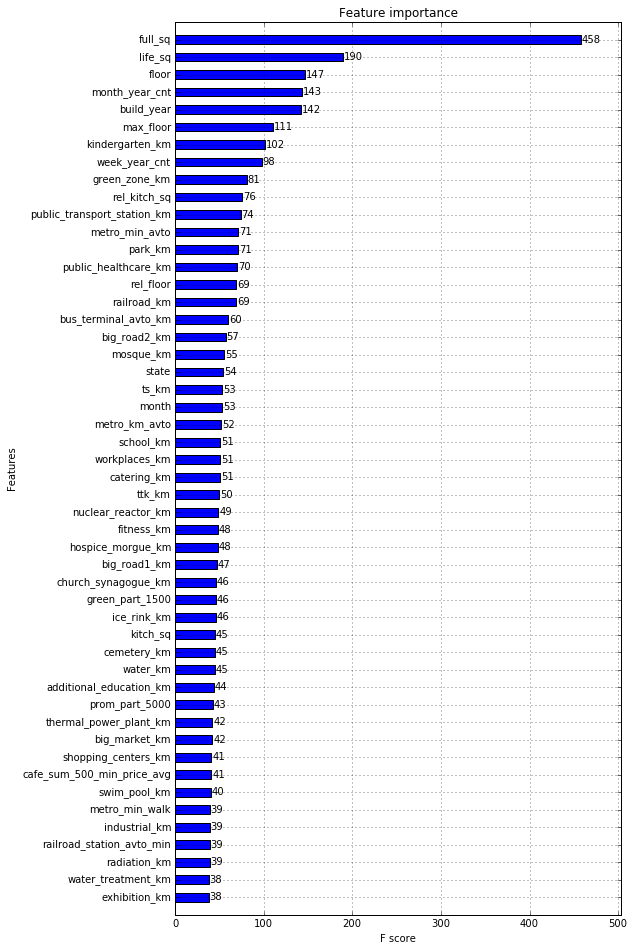

In [278]:
fig, ax = plt.subplots(1, 1, figsize=(8, 16))
xgb.plot_importance(clf, max_num_features=50, height=0.5, ax=ax)
fig.savefig('../submission/'+date+"_"+modelName+".png")